# MS011 Preprocess
Created: 01/25/2024 \
Updated: 04/04/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS011'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/raw/MS011_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3231999  =      0.000 ...  3156.249 secs...


In [7]:
mne_data

<RawEDF | MS011_SWB.edf, 276 x 3232000 (3156.2 s), ~6.65 GB, data loaded>

In [8]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'RmOlF10',
 'RmOlF11',
 'RmOlF12',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'LmCpS1',
 'LmCpS2',
 'LmCpS3',
 'LmCpS4',
 'LmCpS5',
 'LmCpS6',
 'LmCpS7',
 'LmCpS8',
 'LmCpS9',
 'LmCpS10',
 'RmCpS1',
 'RmCpS2',
 'RmCpS3',
 'RmCpS4',
 'RmCpS5',
 'RmCpS6',
 'RmCpS7',
 'RmCpS8',
 'RmCpS9',
 'RmCpS10',
 'C63',
 'C64',
 'LasEnc1',
 'LasEnc2',
 'LasEnc3',
 'LasEnc4',
 'LasEnc5',
 'LasEnc6',
 'LasEnc7',
 'LasEnc8',
 'R Ins1',
 'R lns2',
 'R lns3',
 'R lns4',
 'R lns5',
 'R lns6',
 'R lns7',
 'R lns8',
 'R lns9',
 'R lncs10',
 'R lns11',
 'R lns12',
 'R lns13',
 'R lns14',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAg

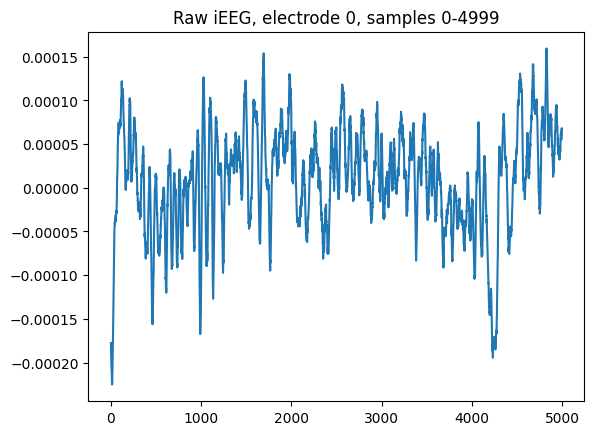

In [9]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Photodiode
- examine photodiode 

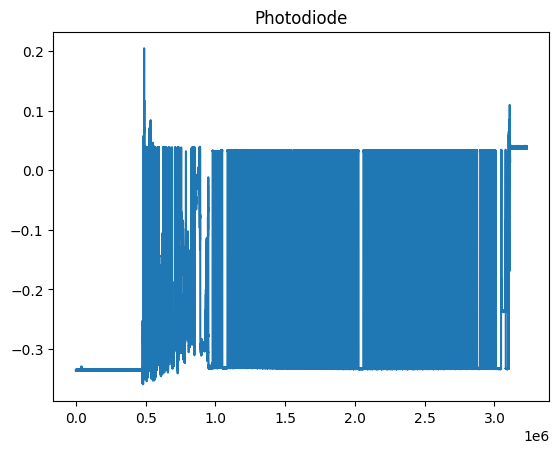

In [10]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("Research")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [11]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='Research', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/photodiode.fif
[done]


In [12]:
mne_data.drop_channels(['Research'])

<RawEDF | MS011_SWB.edf, 275 x 3232000 (3156.2 s), ~6.62 GB, data loaded>

### Resampling data 

In [9]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   38.1s finished


<RawEDF | MS011_SWB.edf, 276 x 1578125 (3156.2 s), ~3.25 GB, data loaded>

### Notch filter line noise

In [10]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   13.2s finished


<RawEDF | MS011_SWB.edf, 276 x 1578125 (3156.2 s), ~3.25 GB, data loaded>

### Anatomical Localization

In [11]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS011_SWB.edf, 276 x 1578125 (3156.2 s), ~3.25 GB, data loaded>

In [12]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCas1,Unknown,-12.131612,38.516561,2.948285,-15.405845,29.575167,-6.324023,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,Left cingulate gyrus C,NaN
1,LaCas2,Unknown,-13.329267,40.514536,7.745699,-16.450350,32.421977,-1.117910,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
2,LaCas3,Unknown,-14.526922,42.112916,12.143328,-17.566868,34.795708,3.729886,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
3,LaCas4,Unknown,-15.724576,44.110891,16.540958,-18.597276,37.555895,8.520236,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,Left cingulate gyrus C,NaN
4,LaCas5,Unknown,-16.922231,46.108866,21.338372,-19.583705,40.416454,13.790957,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,RmTpT5,Unknown,50.146427,-29.414582,-8.245681,44.272789,-45.383760,-5.613669,White,Right Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
132,RmTpT6,Unknown,54.537827,-31.812152,-8.245681,48.484943,-48.102177,-4.833832,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,Unknown,Unknown,WM,NaN
133,RmTpT7,A37dl_R,58.929228,-34.209722,-8.245681,52.750059,-50.933108,-4.156334,Gray,Right MTG middle temporal gyrus,Unknown,R Inferior Temporal Gyrus,R MTG,Right inferior middle temporal gyrus F,NaN,NaN
134,RmTpT8,A37dl_R,63.320628,-36.607292,-7.845897,57.081094,-53.742142,-3.024693,Gray,Right MTG middle temporal gyrus,Unknown,R Inferior Temporal Gyrus,R MTG,Right inferior middle temporal gyrus F,NaN,NaN


In [13]:
list(elec_locs.label)

['LaCas1',
 'LaCas2',
 'LaCas3',
 'LaCas4',
 'LaCas5',
 'LaCas6',
 'LaCas7',
 'LaCas8',
 'LaCas9',
 'LaCas10',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LasEnc1',
 'LasEnc2',
 'LasEnc3',
 'LasEnc4',
 'LasEnc5',
 'LasEnc6',
 'LasEnc7',
 'LasEnc8',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LmCpS1',
 'LmCpS10',
 'LmCpS2',
 'LmCpS3',
 'LmCpS4',
 'LmCpS5',
 'LmCpS6',
 'LmCpS7',
 'LmCpS8',
 'LmCpS9',
 'LmOlF1',
 'LmOlF10',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmTpT1',
 'LmTpT2',
 'LmTpT3',
 'LmTpT4',
 'LmTpT5',
 'LmTpT6',
 'LmTpT7',
 'LmTpT8',
 'RaCas1',
 'RaCas10',
 'RaCas2',
 'RaCas3',
 'RaCas4',
 'RaCas5',
 'RaCas6',
 'RaCas7',
 'RaCas8',
 'RaCas9',
 'RAgIT1',
 'RAgIT2',
 'RAgIT3',
 'RAgIT4',
 'RAgIT5',
 'RAgIT6',
 'RAgIT7',
 'RAgIT8',
 'RHpIT1',
 'RHpIT10',
 'RHpIT2',
 'RHpIT3',
 'RHpIT4',
 'RHpIT5',
 'RHpIT6',
 'RHpIT7',
 'RHpIT8',
 'RHpIT9

In [14]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c63', 'c64', 'rlns2', 'rlns3', 'rlns4', 'rlns5', 'rlns6', 'rlns7', 'rlns8', 'rlns9', 'rlns11', 'rlns12', 'rlns13', 'rlns14', 'laglt1', 'laglt2', 'laglt3', 'laglt4', 'laglt5', 'laglt6', 'laglt7', 'laglt8', 'raglt1', 'raglt2', 'raglt3', 'raglt4', 'raglt5', 'raglt6', 'raglt7', 'raglt8', 'lhplt1', 'lhplt2', 'lhplt3', 'lhplt4', 'lhplt5', 'lhplt6', 'lhplt7', 'lhplt8', 'rhplt1', 'rhplt2', 'rhplt3', 'rhplt4', 'rhplt5', 'rhplt6', 'rhplt7', 'rhplt8', 'rhplt9', 'rhplt10', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 

In [16]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file
      name  lev_score
274  rins1        0.8
275  rlns5        0.8
We have too many possible matches for rins5! Select one manually from these candidates:rlns5
      name  lev_score
274  rins1        0.8
275  rlns4        0.8
We have too many possible matches for rins4! Select one manually from these candidates:rlns4
      name  lev_score
274  rins1        0.8
275  rlns6        0.8
We have too many possible matches for rins6! Select one manually from these candidates:rlns6
      name  lev_score
274  rins1        0.8
275  rlns9        0.8
We have too many possible matches for rins9! Select one manually from these candidates:rlns9
      name  lev_score
274  rins1        0.8
275  rlns2        0.8
We have too many possible matches for rins2! Select one manually from these candidates:rlns2
      name  lev_score
274  rins1        0.8
275  rlns3        0.8
We have too many possible matches fo

In [17]:
unmatched_seeg #make sure there are no unmatched names


[]

In [18]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [19]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'lmolf10': 'lmolf10',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'rmolf10': 'rmolf10',
 'rmolf11': 'rmolf11',
 'rmolf12': 'rmolf12',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 'racas10': 'racas10',
 'lmcps1': 'lmcps1',
 'lmcps2': 'lmcps2',
 'lmcps3': 'lmcps3',
 'lmcps4': 'lmcps4',
 'lmcps5': 'lmcps5',
 

In [20]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS011_SWB.edf, 276 x 1578125 (3156.2 s), ~3.25 GB, data loaded>

In [21]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 62 left sEEG and 75 right sEEG electrodes
We have a total of 137 sEEG electrodes


In [22]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS011_SWB.edf, 276 x 1578125 (3156.2 s), ~3.25 GB, data loaded>

In [23]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS011_SWB.edf, 137 x 1578125 (3156.2 s), ~1.61 GB, data loaded>

In [24]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS011_SWB.edf, 137 x 1578125 (3156.2 s), ~1.61 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [28]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [29]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [30]:
probe_ch_counts

{'lacas': 10,
 'lagit': 8,
 'lasenc': 8,
 'lhpit': 8,
 'lmcps': 10,
 'lmolf': 10,
 'lmtpt': 8,
 'racas': 10,
 'ragit': 8,
 'rhpit': 10,
 'rins': 13,
 'rlncs': 1,
 'rmcps': 10,
 'rmolf': 12,
 'rmtpt': 10}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [31]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lacas10',
 'lmtpt6',
 'lmtpt7',
 'ragit8',
 'rins12',
 'rins9',
 'rlncs10',
 'rmtpt9']

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


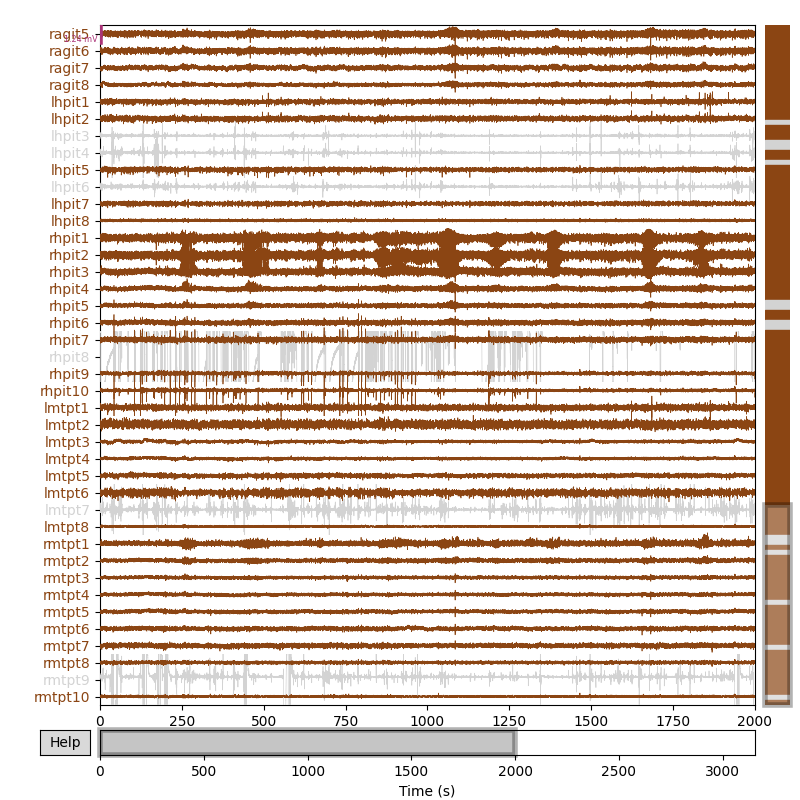

In [32]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=2000, n_channels=40, scalings=mne_data._data.max()/20)
# fig.fake_keypress('a')

In [34]:
# mne_data.info['bads'] = ['rmolf10',
#  'lacas2',
#  'lacas3',
#  'lacas6',
#  'rmcps9',
#  'rmcps4',
#  'rmcps5',
#  'rmcps8',
#  'ragit1',
#  'lhpit3',
#  'lhpit4',
#  'lhpit6',
#  'ragit2',
#  'ragit3',
#  'rhpit1',
#  'rhpit2',
#  'rhpit8',
#  'lmtpt7',
#  'rmtpt1',
#  'rmtpt9',
#  'rhpit4',
#  'lasenc7',
#  'ragit4',
#  'ragit5',
#  'ragit6',
#  'rhpit5',
#  'lmtpt6',
#  'rhpit3',
#  'rhpit10',
#  'rhpit9',
#  'lacas8',
#  'lmcps8',
#  'lhpit1',
#  'lhpit2',
#  'lagit1',
#  'lmtpt1',
#  'lmtpt2',
#  'lmtpt3',
#  'rmolf6'] # old 02/11/2024

In [25]:
mne_data.info['bads'] = ['rmolf10',
 'rmcps8',
 'rmcps9',
 'rmcps4',
 'rmcps5',
 'lacas2',
 'lacas3',
 'lacas6',
 'rhpit8',
 'lhpit6',
 'lhpit4',
 'lhpit3',
 'rmtpt9',
 'lmtpt7']

In [26]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 14 items (rmolf10, rmcps8, rmcps9, rmcps4, rmcps5, lacas2, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 137 sEEG
 custom_ref_applied: False
 dig: 136 items (136 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 16:04:18 UTC
 nchan: 137
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [27]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [28]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is greater than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=53, n_times=1578125
    Range : 0 ... 1578124 =      0.000 ...  3156.248 secs
Ready.
Added the following bipolar channels:
lacas1-lacas4, lacas4-lacas5, lacas7-lacas8, lacas8-lacas9, lagit1-lagit2, lagit3-lagit4, lagit4-lagit5, lagit5-lagit6, lagit6-lagit7, lasenc1-lasenc2, lasenc2-lasenc3, lasenc5-lasenc6, lhpit1-lhpit2, lhpit2-lhpit5, lhpit5-lhpit7, lhpit7-lhpit8, lmcps1-lmcps2, lmcps2-lmcps3, lmcps3-lmcps4, lmcps6-lmcps7, lmcps7-lmcps8, lmolf1-lmolf2, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, lmtpt1-lmtpt2, lmtpt4-lmtpt5, lmtpt5-lmtpt6, lmtpt6-lmtpt8, racas3-racas4, racas4-racas5, racas5-racas6, ragit1-ragit2, ragit4-ragit5, ragit5-ragit6, rhpit1-rhpit2, rhpit2-rhpit3, rhpit3-rhpit4, rhpit4-rhpit5, rhpit5-rhpit6, rins2-rins3, rins3-rins4, rins4-rins5, rins5-rins6, rmcps1-rmcps2, rmcps2-

In [29]:
mne_data_bp_reref

<RawEDF | MS011_SWB.edf, 53 x 1578125 (3156.2 s), ~638.2 MB, data loaded>

In [30]:
mne_data_bp_reref.ch_names

['lacas1-lacas4',
 'lacas4-lacas5',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'lagit1-lagit2',
 'lagit3-lagit4',
 'lagit4-lagit5',
 'lagit5-lagit6',
 'lagit6-lagit7',
 'lasenc1-lasenc2',
 'lasenc2-lasenc3',
 'lasenc5-lasenc6',
 'lhpit1-lhpit2',
 'lhpit2-lhpit5',
 'lhpit5-lhpit7',
 'lhpit7-lhpit8',
 'lmcps1-lmcps2',
 'lmcps2-lmcps3',
 'lmcps3-lmcps4',
 'lmcps6-lmcps7',
 'lmcps7-lmcps8',
 'lmolf1-lmolf2',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmtpt1-lmtpt2',
 'lmtpt4-lmtpt5',
 'lmtpt5-lmtpt6',
 'lmtpt6-lmtpt8',
 'racas3-racas4',
 'racas4-racas5',
 'racas5-racas6',
 'ragit1-ragit2',
 'ragit4-ragit5',
 'ragit5-ragit6',
 'rhpit1-rhpit2',
 'rhpit2-rhpit3',
 'rhpit3-rhpit4',
 'rhpit4-rhpit5',
 'rhpit5-rhpit6',
 'rins2-rins3',
 'rins3-rins4',
 'rins4-rins5',
 'rins5-rins6',
 'rmcps1-rmcps2',
 'rmcps2-rmcps3',
 'rmolf2-rmolf3',
 'rmolf3-rmolf4',
 'rmolf4-rmolf5',
 'rmolf5-rmolf6',
 'rmolf9-rmolf11',
 'rmtpt6-rmtpt7',
 'rmtpt7-rmtpt8']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


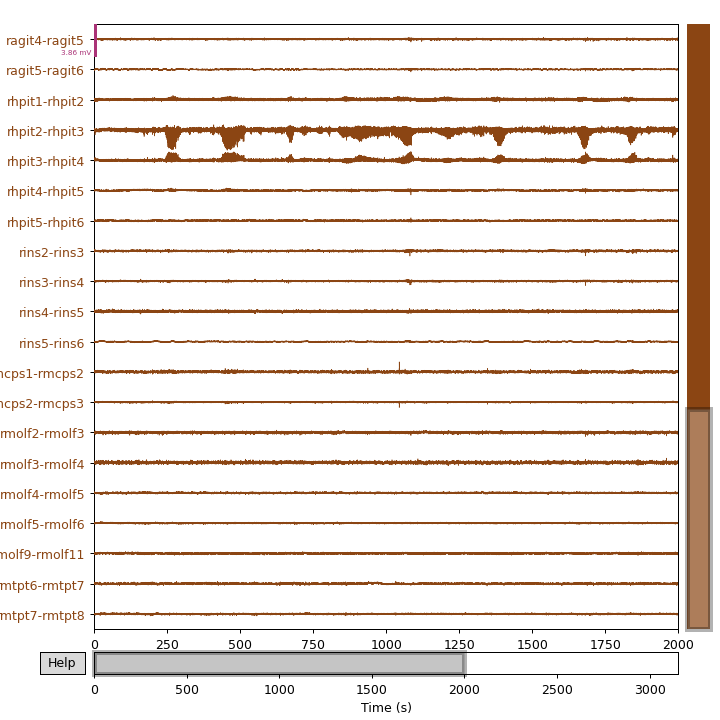

In [10]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=2000, n_channels=20, scalings=mne_data_bp_reref._data.max())
# fig.fake_keypress('a')

Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


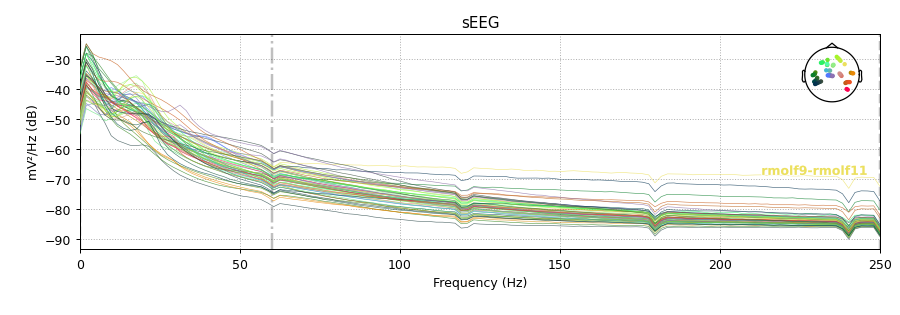

<IPython.core.display.Javascript object>


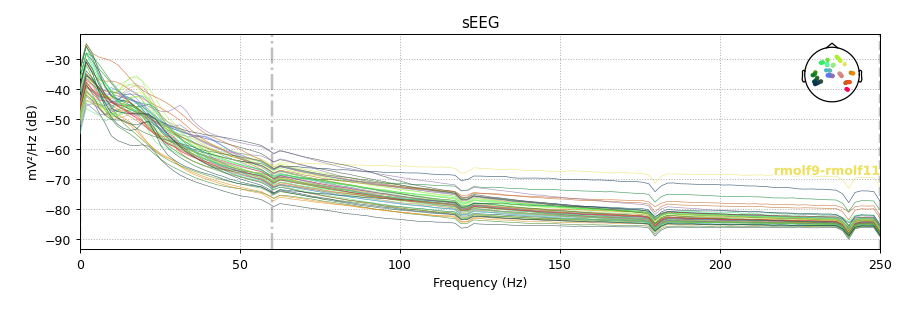

In [11]:
mne_data_bp_reref.compute_psd().plot()

In [31]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/bp_ref_ieeg.fif
[done]


## Save mne_data

In [32]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [33]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [34]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/photodiode.fif...
Isotrak not found
    Range : 0 ... 3231999 =      0.000 ...  3156.249 secs
Ready.
Reading 0 ... 3231999  =      0.000 ...  3156.249 secs...


In [47]:
#resampling if patient is not sampled at 512
resample_sr = 500
photodiode_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


<Raw | photodiode.fif, 1 x 1578125 (3156.2 s), ~12.0 MB, data loaded>

In [48]:
photodiode_data

<Raw | photodiode.fif, 1 x 1578125 (3156.2 s), ~12.0 MB, data loaded>

In [49]:
#### verify photodiode alignment
    # requires newer functions from new sync utils package (older version used here)

def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts


def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


# # moving_average
# neural_ts = get_neural_ts_photodiode(temp_diode, smoothSize=15, height=0.7)
# neural_ts.shape

# pulses = [(x*slope + offset) for x in beh_ts]
# plt.plot(neural_ts,'o')
# # plt.plot(pulses,'o')
# plt.show()

# plt.plot(scipy.stats.zscore(temp_diode._data[0,:]))
# # plt.plot(pulses)
# plt.plot(np.array(pulses)*1024, 
#          np.ones_like(np.array(pulses)*1024)-0.5, '.')
# # plt.plot(neural_ts*1024, 
# #          np.ones_like(neural_ts)-0.25, '.')
# plt.xlim([1900000,2200000])
# plt.show()

# temp_diode = photodiode_data.copy()
# temp_diode._data[0,0:1000000] = np.min(temp_diode._data[0,:])
# temp_diode._data[0,3000000:] = np.min(temp_diode._data[0,:])

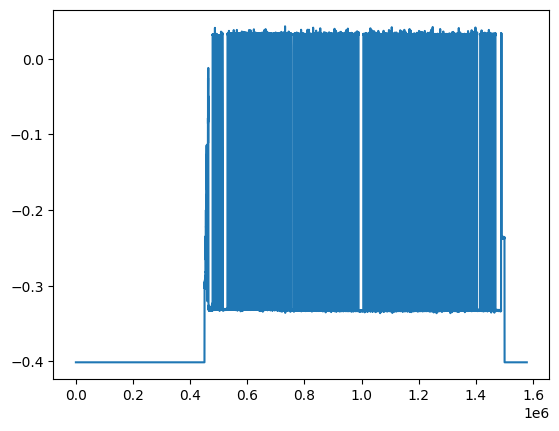

In [54]:
temp_diode = photodiode_data.copy()
temp_diode._data[0,0:450000] = np.min(temp_diode._data[0,:])
temp_diode._data[0,1500000:] = np.min(temp_diode._data[0,:])

plt.plot(temp_diode._data[0,:])
plt.show()

In [55]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.7

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 160 pulses


In [56]:
print(slope, offset,smoothSize,windSize,height)

0.9999938304199576 -90.83079077558068 11 15 0.7


In [57]:
pulses = [(x*slope + offset) for x in beh_ts]

In [58]:
# moving_average
neural_ts = get_neural_ts_photodiode(temp_diode, smoothSize=15, height=0.7)
neural_ts.shape

(160,)

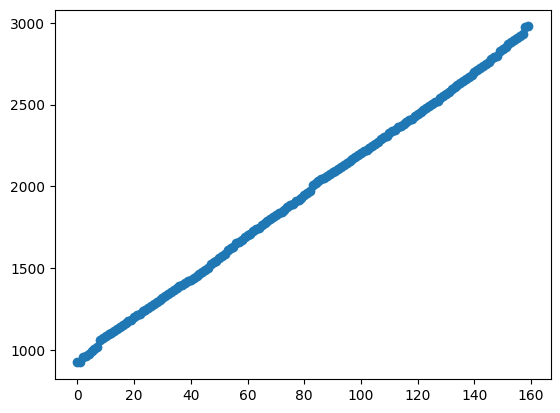

In [59]:
plt.plot(neural_ts,'o')
# plt.plot(pulses,'o')
plt.show()

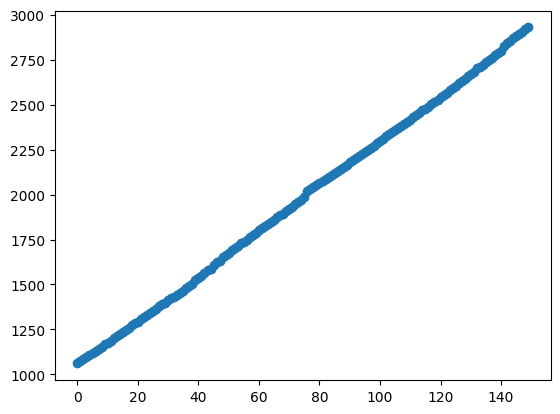

In [60]:
plt.plot(pulses,'o')
plt.show()

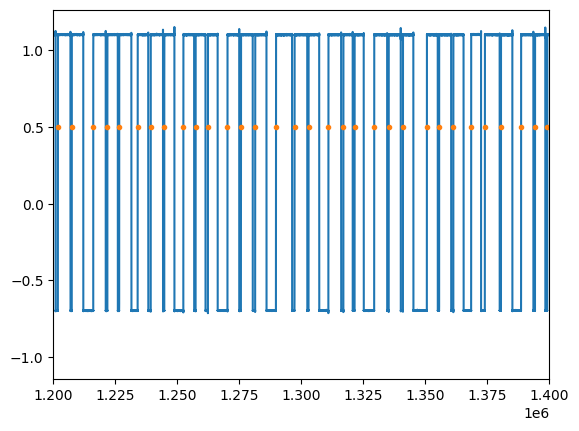

In [66]:
plt.plot(scipy.stats.zscore(temp_diode._data[0,:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*500, 
         np.ones_like(np.array(pulses)*500)-0.5, '.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([1200000,1400000])
plt.show()

In [166]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

In [143]:
# #load behavior data
# behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
# behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df



### Epoch data

In [67]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [68]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [69]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [70]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/bp_ref_ieeg.fif...
    Range : 0 ... 1578124 =      0.000 ...  3156.248 secs
Ready.
Reading 0 ... 1578124  =      0.000 ...  3156.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    4.5s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 53 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/bp_ref_ieeg.fif...
    Range : 0 ... 1578124 =      0.000 ...  3156.248 secs
Ready.
Reading 0 ... 1578124  =      0.000 ...  3156.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  53 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    4.1s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 53 columns


In [71]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~91.2 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~212.5 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [72]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']

In [73]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 75 columns
Replacing existing metadata with 75 columns


In [74]:
epochs_all_evs[event].metadata

,lacas1-lacas4,lacas4-lacas5,lacas7-lacas8,lacas8-lacas9,lagit1-lagit2,lagit3-lagit4,lagit4-lagit5,lagit5-lagit6,lagit6-lagit7,lasenc1-lasenc2,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.58,-0.50,-1.58,-0.50,0.00,0.00,1.58,0.50,0.000,-0.790
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,NaN,...,2.00,0.90,0.00,0.00,2.00,0.90,-1.10,0.00,1.000,0.000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.16,-0.60,-2.16,-0.60,0.00,0.00,2.16,0.60,0.000,-1.080
3,NaN,NaN,NaN,NaN,NaN,noise,NaN,NaN,NaN,NaN,...,0.36,0.16,0.00,0.00,0.36,0.16,0.00,0.20,0.180,0.000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.33,0.33,0.00,0.00,0.33,0.33,-0.73,-0.73,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,noise,NaN,NaN,noise,NaN,noise,NaN,NaN,NaN,...,-0.10,-0.10,-0.10,-0.10,0.00,0.00,0.10,0.10,0.000,0.000
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.55,-0.30,-0.55,-0.30,0.00,0.00,0.25,0.00,0.000,-0.275
147,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.57,-0.57,-0.57,-0.57,0.00,0.00,0.57,0.57,0.000,0.000
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.84,-0.30,-0.84,-0.30,0.00,0.00,0.84,0.30,0.000,-0.420


### Save raw epoched data 

In [75]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [76]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [77]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [78]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [79]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]


temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [80]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 53, ~911.7 MB>}

In [81]:
power_epochs = {}

In [82]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Not setting metadata
Adding metadata with 75 columns


In [83]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 53, ~4.44 GB>

In [84]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [85]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

04072024


In [89]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

In [86]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()


-90.83079077558068
